In [1]:
import numpy as np
import tensorflow as tf

2023-04-26 18:14:00.075184: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Setting up a simple meta-learning environment

First, we set up a meta-learning environment from which we can generate tasks/datasets for meta-training and meta-testing. In particular, we use sinusoid functions with random amplitude and phase shift. Each task corresponds to a sinusoidal function $f_{a,b}(x)$, given as follows:

$$ f_{a,b}(x) = a \sin(x-b) + 5, ~\text{with}~~ a \sim \mathit{U}(2, 4), b \sim \mathit{U}(-2, 2)$$

Given $f_{a,b}(x)$, the data $S = \{(x_1, y_1), ...., (x_m, y_m) \}$ is generated as follows:

$$x_j \sim \mathit{U}(-4, 4), y = f_{a,b}(x_j)) + \epsilon_j ~, ~~ \epsilon_j \sim \mathcal{N}(0, 0.1^2) ~~ \text{for} ~j= 1, ..., m$$

In [2]:
class SinusoidEnv():
    
    def __init__(self, amp_low=2.0, amp_high=3.0, x_shift_low=-2.0, x_shift_high=2.0,
                 x_low=-4.0, x_high=4.0, noise_std=0.1, seed=234):
        self.amp_low = amp_low
        self.amp_high = amp_high
        self.x_shift_low = x_shift_low
        self.x_shift_high = x_shift_high
        self.x_low = x_low
        self.x_high = x_high
        self.noise_std = noise_std
        self.random_state = np.random.RandomState(seed)

    def _sample_sinusoid_fn(self):
        amplitude = self.random_state.uniform(self.amp_low, self.amp_high)
        x_shift = self.random_state.uniform(self.x_shift_low, self.x_shift_high)
        return lambda x: amplitude * np.sin((x - x_shift)) + 5.0

    def generate_meta_train_data(self, n_tasks, n_samples):
        meta_train_tuples = []
        for i in range(n_tasks):
            f = self._sample_sinusoid_fn()
            X = self.random_state.uniform(self.x_low, self.x_high, size=(n_samples, 1))
            Y = f(X) + self.noise_std * self.random_state.normal(size=f(X).shape)
            meta_train_tuples.append((X, Y))
        return meta_train_tuples

    def generate_meta_test_data(self, n_tasks, n_samples_context, n_samples_test):
        assert n_samples_test > 0
        meta_test_tuples = []
        for i in range(n_tasks):
            f = self._sample_sinusoid_fn()
            X = self.random_state.uniform(self.x_low, self.x_high, size=(n_samples_context + n_samples_test, 1))
            Y = f(X) + self.noise_std * self.random_state.normal(size=f(X).shape)
            meta_test_tuples.append(
                (X[:n_samples_context], Y[:n_samples_context], X[n_samples_context:], Y[n_samples_context:]))

        return meta_test_tuples

### Generate meta-train and meta-test data

For each task the learner gets only 5 training points. For evaluation, we use 200 points.

In [3]:
env = SinusoidEnv()
meta_train_data = env.generate_meta_train_data(n_tasks=200, n_samples=5)
meta_test_data = env.generate_meta_test_data(n_tasks=20, n_samples_context=5, n_samples_test=200)

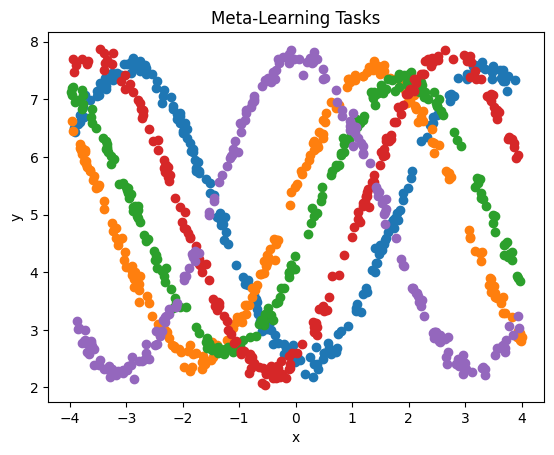

In [4]:
from matplotlib import pyplot as plt
%matplotlib inline
for x_context, y_context, x_test, y_test in meta_test_data[:5]:
    plt.scatter(x_test, y_test)
plt.title('Meta-Learning Tasks')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

## Training a Standard Bayesian Neural Network 

Now, we train a standard Bayesian Neural Network (BNN) with zero-centered, sperical Gaussian prior $P(\theta) = \mathcal{N}(0, \sigma_P^2 \mathbf{I})$.

100%|█| 500/500 [00:07<00:00, 66.43it/s, loss=35.4, avg_ll=-96.5, avg_rmse=1.86,
100%|█| 500/500 [00:07<00:00, 66.14it/s, loss=58.1, avg_ll=-110, avg_rmse=1.63, 


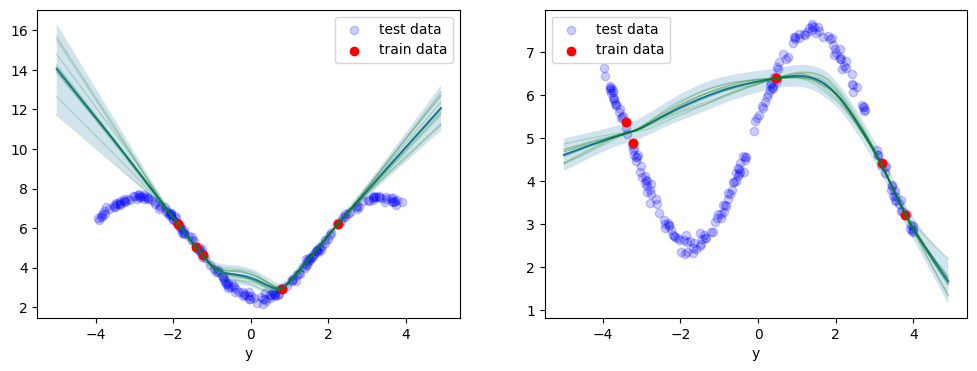

In [5]:
import warnings
import warnings
warnings.filterwarnings("ignore")

from pacoh_nn.bnn import BayesianNeuralNetworkSVGD

fig, axes = plt.subplots(1, 2, figsize=(12.0, 4.0))
for i in range(2):
    x_context, y_context, x_test, y_test = meta_test_data[i]
    
    # setting up and fitting the BNN
    bnn = BayesianNeuralNetworkSVGD(x_context, y_context, hidden_layer_sizes=(64, 64, 64, 64), prior_weight=0.001, bandwidth=1000.0)
    bnn.fit(x_val=x_test, y_val=y_test, num_iter_fit=500, log_period=500)
    
    # plotting
    x_plot = tf.range(-5, 5, 0.1)
    bnn.plot_predictions(x_plot, ax=axes[i])
    axes[i].scatter(x_test, y_test, color='blue', alpha=0.2, label="test data")
    axes[i].scatter(x_context, y_context, color='red', label="train data")
    axes[i].legend()
    axes[i].set_xlabel('x')
    axes[i].set_xlabel('y')

fig.show()

Since this prior is pretty uninformative, it provides poor inductive bias. As we can see in the plots below, the learned posterior prediction do not generalize well beyond the training data. Moreover, the majority of test points lie outside the confidence regions of the posterior, indicating poorly calibrated uncertainty estimates.

## Meta-Learning a BNN Prior with PACOH-NN

### Meta-Training

Now, we use PACOH-NN to meta-learn a prior that exhibits the inductive bias our sinusoidal environment. During the meta-training process, we plot functions sampled from the (learned) prior to visually inspect how the prior evolves.

2023-04-22 15:56:02.650921: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [5,1]
	 [[{{node Placeholder/_1}}]]
2023-04-22 15:56:02.651280: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [5,1]
	 [[{{node Placeholder/_0}}]]
2023-04-22 15:56:02.658552: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [5,1]
	 [[

2023-04-22 15:56:02.844625: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [5,1]
	 [[{{node Placeholder/_1}}]]
2023-04-22 15:56:02.851460: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [5,1]
	 [[{{node Placeholder/_0}}]]
2023-04-22 15:56:02.851696: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [5,1]
	 [[

2023-04-22 15:56:03.078889: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [5,1]
	 [[{{node Placeholder/_1}}]]
2023-04-22 15:56:03.079268: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [5,1]
	 [[{{node Placeholder/_0}}]]
2023-04-22 15:56:03.091959: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [5,1]
	 [[

2023-04-22 15:56:03.285344: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [5,1]
	 [[{{node Placeholder/_0}}]]
2023-04-22 15:56:03.285747: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [5,1]
	 [[{{node Placeholder/_0}}]]
2023-04-22 15:56:03.293385: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [5,1]
	 [[

2023-04-22 15:56:03.501700: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [5,1]
	 [[{{node Placeholder/_1}}]]
2023-04-22 15:56:03.502304: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [5,1]
	 [[{{node Placeholder/_0}}]]
2023-04-22 15:56:03.536784: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [5,1]
	 [[

2023-04-22 15:56:04.030024: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [5,1]
	 [[{{node Placeholder/_1}}]]
2023-04-22 15:56:04.030587: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [5,1]
	 [[{{node Placeholder/_1}}]]
2023-04-22 15:56:04.041869: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [5,1]
	 [[

2023-04-22 15:56:04.231354: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [5,1]
	 [[{{node Placeholder/_1}}]]
2023-04-22 15:56:04.244890: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [5,1]
	 [[{{node Placeholder/_1}}]]
2023-04-22 15:56:04.245250: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [5,1]
	 [[

2023-04-22 15:56:04.435766: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [5,1]
	 [[{{node Placeholder/_1}}]]
2023-04-22 15:56:04.457884: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [5,1]
	 [[{{node Placeholder/_1}}]]
2023-04-22 15:56:04.458319: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [5,1]
	 [[

2023-04-22 15:56:04.646474: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [5,1]
	 [[{{node Placeholder/_0}}]]
2023-04-22 15:56:04.646853: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [5,1]
	 [[{{node Placeholder/_0}}]]
2023-04-22 15:56:04.661928: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [5,1]
	 [[

Start meta-training -------------------- 


2023-04-22 15:56:18.740739: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]


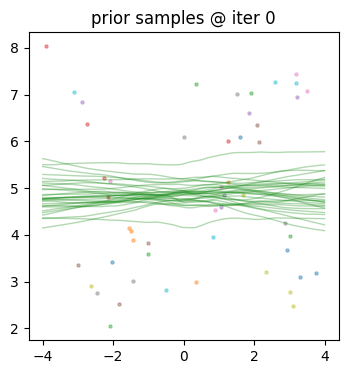


Iter 0/20000 - Time 32.19 sec - Train-Loss: -865.33771

Iter 1000/20000 - Time 21.38 sec - Train-Loss: -196.36308

Iter 2000/20000 - Time 25.23 sec - Train-Loss: -205.90874

Iter 3000/20000 - Time 22.31 sec - Train-Loss: -90.42452


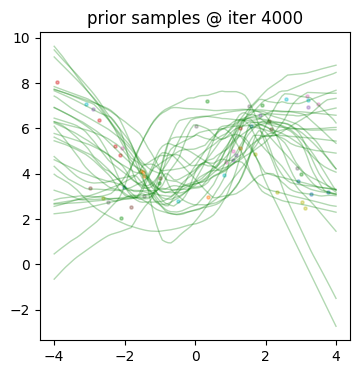


Iter 4000/20000 - Time 25.38 sec - Train-Loss: -298.18933

Iter 5000/20000 - Time 18.34 sec - Train-Loss: -156.81595

Iter 6000/20000 - Time 19.11 sec - Train-Loss: -149.39665

Iter 7000/20000 - Time 19.53 sec - Train-Loss: -133.59865


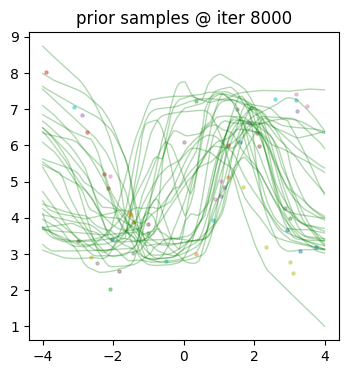


Iter 8000/20000 - Time 20.63 sec - Train-Loss: -163.67041

Iter 9000/20000 - Time 20.44 sec - Train-Loss: -115.49764


2023-04-22 16:00:14.673556: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [5,1]
	 [[{{node Placeholder/_1}}]]
2023-04-22 16:00:14.673827: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [5,1]
	 [[{{node Placeholder/_1}}]]
2023-04-22 16:00:14.682238: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [200,1]
	 

	Start meta-test posterior inference in 2 batches ------------------
	Meta-Test batch #1 consisting of 5 tasks----
	Meta-Test batch #2 consisting of 5 tasks----

Iter 10000/20000 - Time 19.84 sec - Train-Loss: -108.59080- Val-cal_err: 0.099 +- 0.059- Val-avg_ll: -0.660 +- 0.227- Val-avg_rmse: 0.678 +- 0.252

Iter 11000/20000 - Time 32.37 sec - Train-Loss: -248.33215


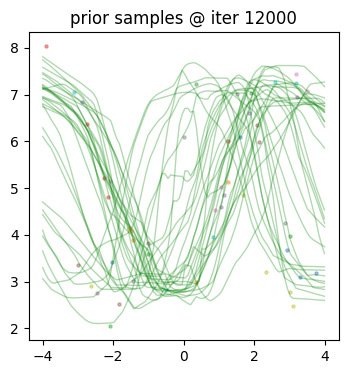


Iter 12000/20000 - Time 20.55 sec - Train-Loss: -93.67898

Iter 13000/20000 - Time 19.84 sec - Train-Loss: -70.46684

Iter 14000/20000 - Time 24.89 sec - Train-Loss: -69.53091

Iter 15000/20000 - Time 23.10 sec - Train-Loss: -155.20256


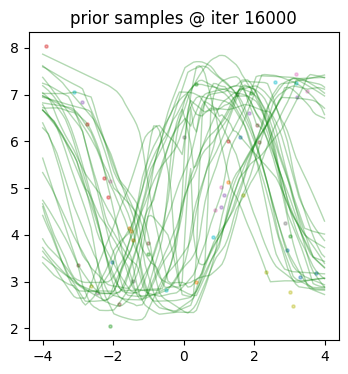


Iter 16000/20000 - Time 22.99 sec - Train-Loss: -77.95874

Iter 17000/20000 - Time 23.92 sec - Train-Loss: -69.27172

Iter 18000/20000 - Time 24.60 sec - Train-Loss: -65.77393

Iter 19000/20000 - Time 22.58 sec - Train-Loss: -44.91715


40.136177

In [8]:
from pacoh_nn.pacoh_nn_regression import PACOH_NN_Regression
pacoh_model = PACOH_NN_Regression(meta_train_data, random_seed=22, num_iter_meta_train=20000, num_iter_meta_test=3000,
                                  learn_likelihood=False, likelihood_std=0.1, hyper_prior_weight=1e-4)



pacoh_model.meta_fit(meta_test_data[:10], eval_period=10000, log_period=1000,
                     plot_prior_during_training=True, plot_period=4000)

As we can see in the plots this is actually the case. Throughout the process of meta-training, PACOH-NN meta-learns inductive bias towards sinusoidal function shapes.

### Meta-Testing

Finally, we perform meta-testing to see whether our meta-learned prior actually improves the BNN posterior predictions.

2023-04-22 16:09:07.515114: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [5,1]
	 [[{{node Placeholder/_0}}]]
2023-04-22 16:09:07.515559: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [5,1]
	 [[{{node Placeholder/_1}}]]
100%|██████████████████████████| 3000/3000 [00:17<00:00, 172.26it/s, loss=-70.1]
2023-04-22 16:09:26.573195: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a va

2023-04-22 16:09:45.205469: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [5,1]
	 [[{{node Placeholder/_1}}]]
2023-04-22 16:09:45.205921: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [5,1]
	 [[{{node Placeholder/_1}}]]
2023-04-22 16:09:45.213765: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [200,1]
	 

	Start meta-test posterior inference in 4 batches ------------------
	Meta-Test batch #1 consisting of 5 tasks----
	Meta-Test batch #2 consisting of 5 tasks----
	Meta-Test batch #3 consisting of 5 tasks----
	Meta-Test batch #4 consisting of 5 tasks----
cal_err: 0.1100 +- 0.0434
avg_ll: -0.8774 +- 0.5866
avg_rmse: 0.8508 +- 0.2717


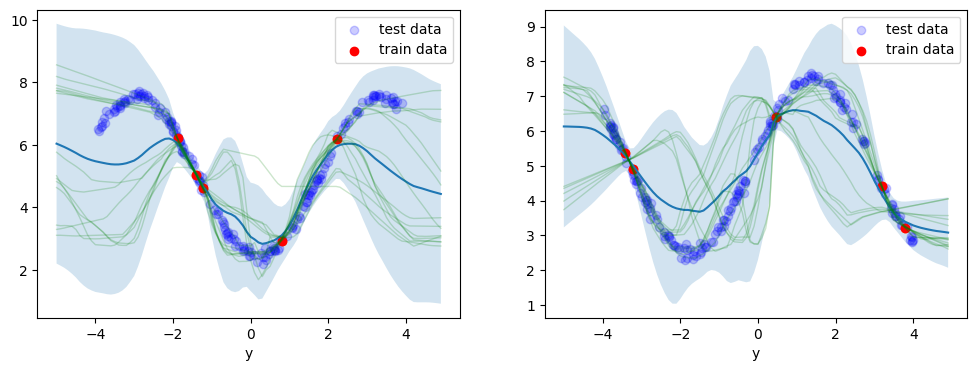

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(12.0, 4.0))
for i in range(2):
    x_context, y_context, x_test, y_test = meta_test_data[i]
    
    # plotting
    x_plot = tf.range(-5, 5, 0.1)
    pacoh_model.plot_posterior(x_context, y_context, x_plot, ax=axes[i])
    axes[i].scatter(x_test, y_test, color='blue', alpha=0.2, label="test data")
    axes[i].scatter(x_context, y_context, color='red', label="train data")
    axes[i].legend()
    axes[i].set_xlabel('x')
    axes[i].set_xlabel('y')

fig.show()

eval_metrics_mean, eval_metrics_std = pacoh_model.meta_eval_datasets(meta_test_data)
for key in eval_metrics_mean:
    print("%s: %.4f +- %.4f"%(key, eval_metrics_mean[key], eval_metrics_std[key]))

Now the posterior prediction generalize much better beyond the training data. 
Moreover, the confidence intervals of the posterior contain the test points. 
Overall, this suggests that the meta-learned prior conveys useful inductive bias.